In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import function as f
import re
import os

In [84]:
def create_congestion_df(_folderPath):
    csv_data = f.load_csv_files_in_folder(_folderPath)
    folder_name = os.path.basename(os.path.normpath(_folderPath))
    
    prev_truck_num = re.findall(r'prev_(\d+)', folder_name)[0]
    now_truck_num = re.findall(r'now_(\d+)', folder_name)[0]

    columns = ["Prev Truck Number", "Now Truck Number", "repeat_num", "alpha_1", "alpha_2", "alpha_3"] + csv_data[0][1][0]

    wt_data_list = []
    wot_data_list = []


    for file_name, file_data in csv_data:
        
        alphas_match = re.search(r"LP_(\d+)_(\d+)_(\d+)", file_name)
        
        if alphas_match:
            alpha1 = int(alphas_match.group(1))
            alpha2 = int(alphas_match.group(2))
            alpha3 = int(alphas_match.group(3))
            
            alphas = [alpha1, alpha2, alpha3]
            
        # remove .csv
        repeat_time = file_name.split('_')[-1].split('.')[0]
        
        # if repeat_time doesn't contain "rep"
        if "rep" in repeat_time:
            if repeat_time[0] == '0':
                repeat_time = '1'
        
        else:
            repeat_time = '1'
        
        for row in file_data[1:]:
            # print(row)
            row[4:] = [float(value) for value in row[4:]]
            new_row = [prev_truck_num, now_truck_num, repeat_time] + alphas + row
            
            if 'NoCongestions' in file_name:
                wot_data_list.append(new_row)
            else:
                wt_data_list.append(new_row)

    wt_df = pd.DataFrame(wt_data_list, columns=columns)
    wot_df = pd.DataFrame(wot_data_list, columns=columns)
    
    # remove unnecessary columns : "Origin", "Destination", "Route-id"
    wt_df = wt_df.drop(['Origin', 'Destination', 'Route_id'], axis=1)
    wot_df = wot_df.drop(['Origin', 'Destination', 'Route_id'], axis=1)
    
    return wt_df, wot_df

In [123]:
def get_congestion_ratio_df(_folder_path):

    wt_df, wot_df = create_congestion_df(_folder_path)
    # Perform the subtraction and division
    merged_df = wt_df.merge(wot_df, on=['Prev Truck Number', 'Now Truck Number', 'alpha_1', 'repeat_num', 'alpha_2', 'alpha_3', 'Truck_id'], suffixes=('_wt', '_wot'))
    merged_df['Pickup_Congestion_ratio'] = (merged_df['PickupSta AT_wt'] - merged_df['PickupSta AT_wot'])/merged_df['PickupSta AT_wot']
    merged_df['Drop_Congestion_ratio'] = (merged_df['DropSta AT_wt'] - merged_df['DropSta AT_wot'])/merged_df['DropSta AT_wot']
    # alpha값들에 따라서 그룹화를 한후 Pickup_Congestion_ratio, Drop_Congestion_ratio의 전체 평균을 구한다.
    merged_df_congestion_ratio = merged_df.groupby(['alpha_1', 'alpha_2', 'alpha_3'])[['Pickup_Congestion_ratio', 'Drop_Congestion_ratio']].mean()

    # index to column
    merged_df_congestion_ratio = merged_df_congestion_ratio.reset_index()

    # 각 행별로 평균 구하기
    merged_df_congestion_ratio['Congestion_ratio'] = (merged_df_congestion_ratio['Pickup_Congestion_ratio'] + merged_df_congestion_ratio['Drop_Congestion_ratio'])/2
    # drop unnecessary columns
    merged_df_congestion_ratio = merged_df_congestion_ratio.drop(['Pickup_Congestion_ratio', 'Drop_Congestion_ratio'], axis=1)
    return merged_df_congestion_ratio

In [160]:
def draw_plot_congestion(_df, _x_label, _y_label):

    # 현재 스케줄링 대상 트럭
    x_value_2 = _df["alpha_1"]
    y_value_2 = _df["Congestion_ratio"]

    # 그래프 그리기
    plt.figure(figsize=(5,3))
    # plt.plot(x_value_1, y_value_1 , marker='o', linestyle='-', color = 'steelblue')
    plt.plot(x_value_2, y_value_2 , marker='o', linestyle='-', color = 'blue')

    plt.xlabel(_x_label, fontsize=9)
    plt.ylabel(_y_label, fontsize=9)

    # plt.ylim(int(y_value_2.min()) - 0.05, int(y_value_2.max()) + 0.05)
    
    plt.axhline(y=y_value_2.iloc[0], color='gray', linestyle='--')

    plt.show()

In [215]:
def Create_subplot_congestion(_directory_path, _x_label, _y_label, _title, row_num, col_num, fig_size):
    
    folder_name_list = []
    congestion_df_list = []
    
    for folder_name in os.listdir(_directory_path):
        
        # 확장자 얻기
        extension = os.path.splitext(folder_name)[-1]

        # .csv 파일만 가져오기
        if extension != '.meta':
            folder_path = os.path.join(_directory_path, folder_name)
            
            if os.path.isdir(folder_path):
                folder_name_list.append(folder_name)
                
                congestion_df = get_congestion_ratio_df(folder_path)
                congestion_df_list.append(congestion_df)
                            
            else:
                print("Please Check Directory Path")
    
    f, axes = plt.subplots(row_num, col_num)
    
    # 격자 크기 설정
    f.set_size_inches(fig_size)

    # 격자 여백 설정
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
    
    row_index = 0
    col_index = 0
    
    for i in range(len(congestion_df_list)):

        x_value_1 = congestion_df_list[i]["alpha_1"]
        y_value_1 = congestion_df_list[i]['Congestion_ratio']
        
        if row_num == 1:
            plt.subplot(1, col_num, col_index + 1)
            plt.plot(x_value_1, y_value_1 , marker='o', linestyle='-', color = 'steelblue')

            plt.xlabel(_x_label, fontsize=9, ha='center')
            plt.ylabel(_y_label, fontsize=9)
            # x축 10 단위로 표시
            # plt.xticks(range(x_value_1.min(), x_value_1.max() + 10, 10))
            plt.title(_title + ' (' + folder_name_list[i] + ')', fontsize=9, ha='center')
            plt.axhline(y=y_value_1.iloc[0], color='gray', linestyle='--')
            
        else:
            # x축 10 단위로 표시
            # axes[row_index, col_index].set_xticks(range(x_value_1.min(), x_value_1.max() + 10, 10))
            axes[row_index, col_index].plot(x_value_1, y_value_1 , marker='o', linestyle='-', color = 'steelblue')
            plt.axhline(y=y_value_1.iloc[0], color='gray', linestyle='--')
            
            # title_name = "Completion Time by alpha_1 (prev_20_now_20)"
            title_name = _title +  ' (' + folder_name_list[i] + ')'
            
            axes[row_index, col_index].set_xlabel(_x_label, fontsize=9, ha='center')
            axes[row_index, col_index].set_ylabel(_y_label, fontsize=9)
            axes[row_index, col_index].set_title(title_name, fontsize=9, ha='center')

        col_index += 1
        if(col_index == col_num):
            col_index = 0
            row_index += 1
        
    plt.show()

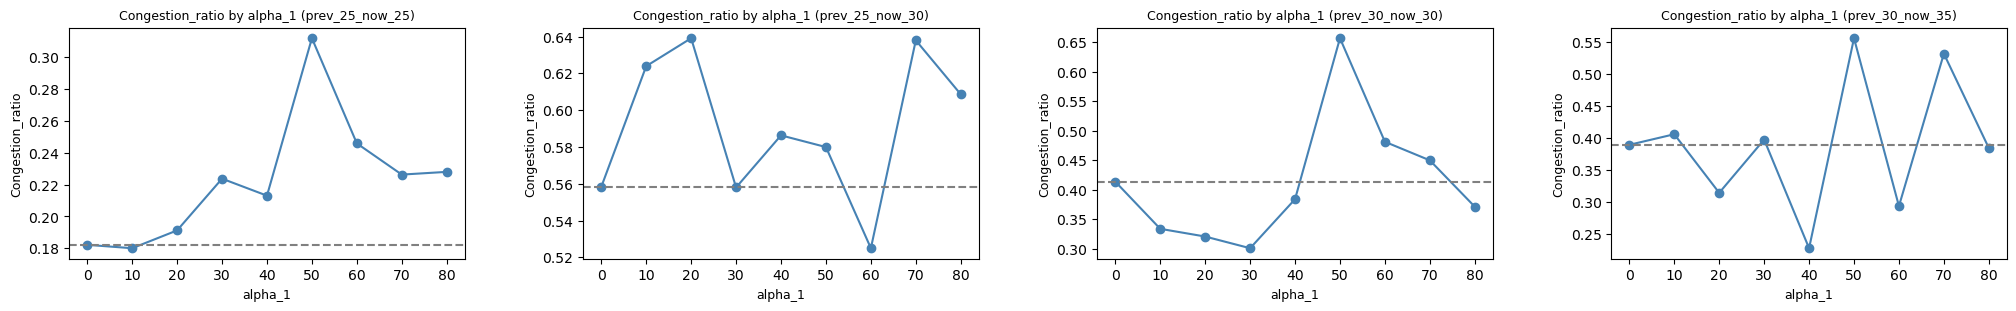

In [220]:
directory_path = '../Simulation/Assets/Results/Congestion'
x_label = 'alpha_1'
y_label = 'Congestion_ratio'
title = 'Congestion_ratio by alpha_1'
row_num = 1
col_num = 4
Create_subplot_congestion(directory_path, x_label, y_label, title, row_num, col_num, (25, 3))

### prev_25_now_25

In [179]:
folder_path = '../Simulation/Assets/Results/Congestion/prev_25_now_25/'

prev_25_now_25_congestion_df = get_congestion_ratio_df(folder_path)
prev_25_now_25_congestion_df

,alpha_1,alpha_2,alpha_3,Congestion_ratio
0,0,0,100,0.182137
1,10,80,10,0.180010
2,20,70,10,0.191204
3,30,60,10,0.223685
4,40,50,10,0.213016
5,50,40,10,0.311886
6,60,30,10,0.245835
7,70,20,10,0.226248
8,80,10,10,0.227957


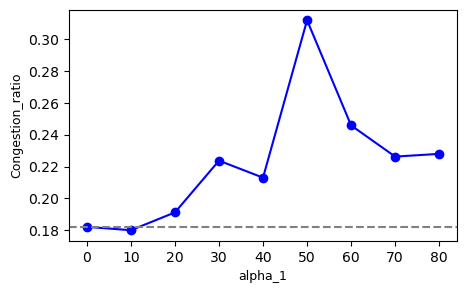

In [180]:
title_name = 'Prev 25, Now 25'
x_label = 'alpha_1'
y_label = 'Congestion_ratio'

draw_plot_congestion(prev_25_now_25_congestion_df, x_label, y_label)

### Prev 25 now 30

In [181]:
folder_path = '../Simulation/Assets/Results/Congestion/prev_25_now_30/'

prev_25_now_30_congestion_df = get_congestion_ratio_df(folder_path)
prev_25_now_30_congestion_df

,alpha_1,alpha_2,alpha_3,Congestion_ratio
0,0,0,100,0.558306
1,10,80,10,0.623897
2,20,70,10,0.639071
3,30,60,10,0.557985
4,40,50,10,0.586299
5,50,40,10,0.579937
6,60,30,10,0.524978
7,70,20,10,0.637934
8,80,10,10,0.608606


In [182]:
x_value = prev_25_now_30_congestion_df['alpha_1']
y_value = prev_25_now_30_congestion_df['Congestion_ratio']
title_name = 'Prev 25, Now 30'
x_label = 'alpha_1'
y_label = 'Congestion_ratio'

draw_plot_congestion(x_value, y_value, title_name, x_label, y_label)

TypeError: draw_plot_congestion() takes 3 positional arguments but 5 were given

In [ ]:
folder_path = '../Simulation/Assets/Results/Congestion/prev_30_now_30/'

prev_30_now_30_congestion_df = get_congestion_ratio_df(folder_path)
prev_30_now_30_congestion_df

,alpha_1,alpha_2,alpha_3,Congestion_ratio
0,0,0,100,0.413659
1,10,80,10,0.333862
2,20,70,10,0.320810
3,30,60,10,0.301027
4,40,50,10,0.383999
5,50,40,10,0.656420
6,60,30,10,0.481161
7,70,20,10,0.449744
8,80,10,10,0.371311


In [ ]:
folder_path = '../Simulation/Assets/Results/Congestion/prev_30_now_35/'

prev_30_now_35_congestion_df = get_congestion_ratio_df(folder_path)
prev_30_now_35_congestion_df

,alpha_1,alpha_2,alpha_3,Congestion_ratio
0,0,0,100,0.388791
1,10,80,10,0.405343
2,20,70,10,0.313747
3,30,60,10,0.396984
4,40,50,10,0.227141
5,50,40,10,0.555460
6,60,30,10,0.292945
7,70,20,10,0.531265
8,80,10,10,0.383864


KeyError: 'Prev Truck Number'

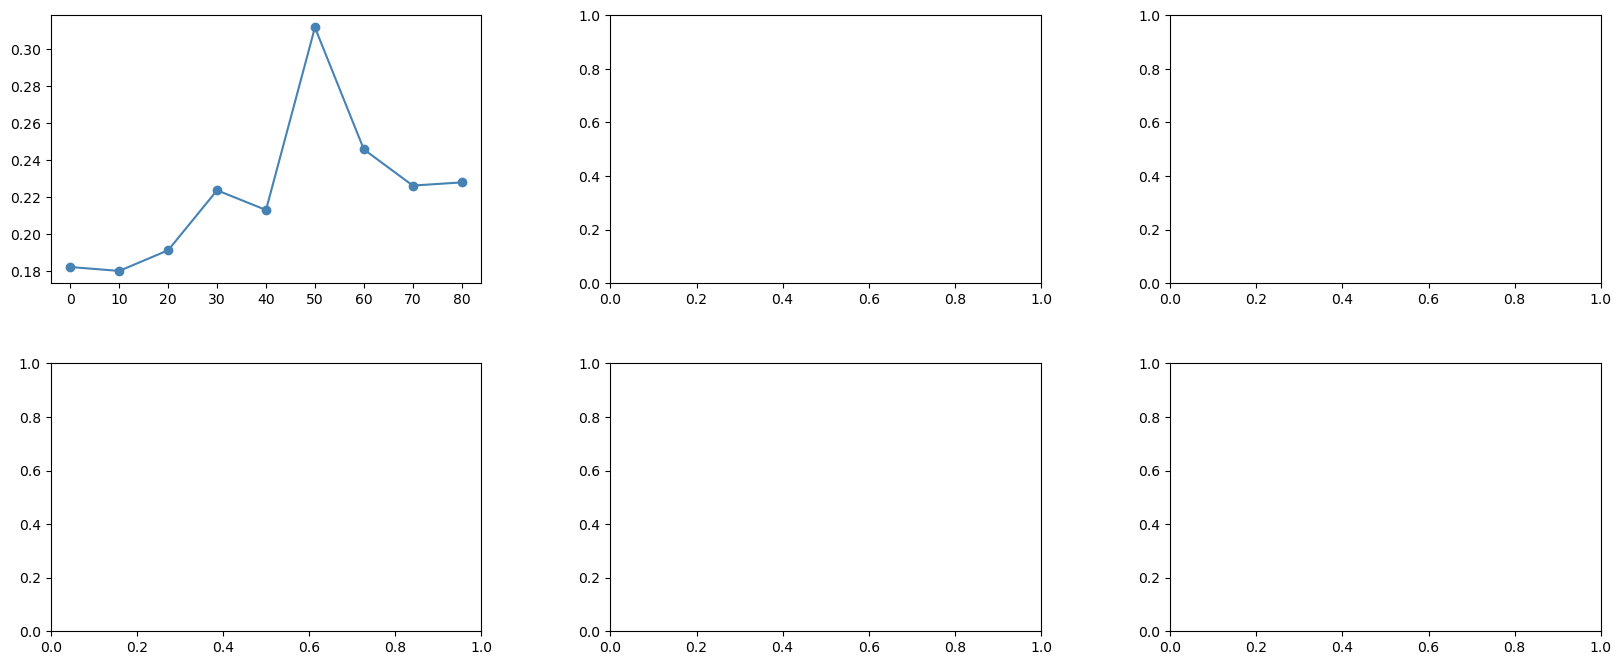

In [ ]:
dfs = [prev_25_now_25_congestion_df, prev_25_now_30_congestion_df, prev_30_now_30_congestion_df, prev_30_now_35_congestion_df]

x_label = "alpha_1"
y_label = "Congestion_ratio"
title = "Congestion ratio by alpha_1"


Create_subplot_congestion(dfs, x_label, y_label, title, 2, 3, (20, 8))